# <center> Майнор "Интеллектуальный анализ данных" </center>

# <center> Курс "Современные методы машинного обучения" </center>

# <center> Лабораторная работа №2. Deep Learning. </center>

В данной лабораторной работе вам предлагается обучить модель на основе нейронной сети для распознавания рукописных букв английского алфавита.

## Данные

Данные представлены двумя датасетами: обучающим (`train`) и тестовым (`test`). Изображения для каждого датасета находятся в `images.zip`.  
  
Обучающая выборка состоит из 65000 изображений - по 2500 изображений для каждой буквы.  
Тестовая выборка состоит из 13000 изображений - по 500 изображений для каждой буквы.  
  
Все изображения - монохромные (но в формате RGB), размерности $28 \times 28$ пикселей, в формате JPEG. 
В названии каждого файла содержатся буква, которая представлена на изображении, и уникальный номер изображения: `a_00002.jpg`.  
  
**NB:** Все изображения представлены в перевернутом виде, для корректного отображения их нужно сначала транспонировать. 

In [1]:
import numpy as np
import pandas as pd

# отображение в jupyter'e
%matplotlib inline
import matplotlib.pyplot as plt

# более чёткое отображение графиков
%config InlineBackend.figure_format = 'svg' 

# увеличение дефолтного размера графиков
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

# отключение предупреждений Anaconda
import warnings
warnings.simplefilter('ignore')

In [2]:
pic = plt.imread('images/train/a/a_00002.jpg')
print(pic.shape)

(28, 28, 3)


In [3]:
pic = np.transpose(pic, axes=(1, 0, 2))

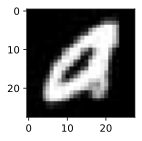

In [4]:
plt.figure(figsize=(2,2))
plt.imshow(pic)
plt.show()

In [5]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F # модуль, где определены активации для слоев нейронных сетей
import torchvision.transforms as transforms

In [6]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [7]:
train_data = torchvision.datasets.ImageFolder(root='./images/train/', transform=transform)
test_data = torchvision.datasets.ImageFolder(root='./images/test/', transform=transform)

In [8]:
df = pd.DataFrame({'Index': np.arange(len(train_data.classes)),
                   'Letter': list(train_data.classes)})
df

,Index,Letter
0,0,a
1,1,b
2,2,c
3,3,d
4,4,e
5,5,f
6,6,g
7,7,h
8,8,i
9,9,j


In [9]:
train_data.target_transform = lambda id: int(train_data.classes[id])
test_data.target_transform = lambda id: int(test_data.classes[id])

In [10]:
classes = train_data.classes

In [11]:
train_data.classes = df.Index.to_list()
test_data.classes = df.Index.to_list()

In [12]:
batch_size = 26

In [13]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [14]:
dataiter = iter(train_loader)
# батч картинок и батч ответов к картинкам
images, labels = dataiter.next()

In [15]:
images.shape, labels.shape

(torch.Size([26, 3, 28, 28]), torch.Size([26]))

**Comment:** *Посмотрим примеры букв из тренировочной выборки:*

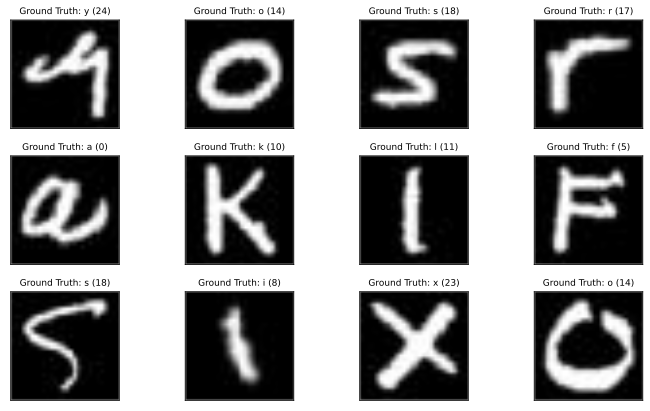

In [16]:
fig = plt.figure(figsize=(10, 6))

for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.tight_layout()
    plt.imshow(np.transpose(images[i][0].numpy()), cmap='gray', interpolation='none')
    plt.title("Ground Truth: {} ({})".format(classes[labels[i]], labels[i]), fontsize=9)
    plt.xticks([])
    plt.yticks([])
    
plt.show()

**Comment:** *На первый взгляд распознавание букв будет происходить сложно, потому что, например, `y` из первой картинки даже человеку сложно распознать с первого раза, не приняв её за `m`. Аналогичная ситуация и с буквой `i`, у которой отличительная черта - точка - не расположена в зоне рисунка (легко спутать с `l`).*

## Основные задания

Ваша задача - создать и обучить модель на основе нейронной сети, которая будет предсказывать букву на картинке.  
Обучение необходимо проводить на данных из `train`, качество модели проверять на данных из `test`.  
Целевая метрика - accuracy.  
Для моделирования необходимо использовать `pytorch`.

### Задание 1  
  
*Вес в общей оценке - 0.35*  
  
1. Постройте и обучите модели с 2-мя и 3-мя полносвязными (dense) скрытыми слоями.  
При моделировании необходимо попробовать разные параметры нейронной сети - число нейронов на каждом слое, learning rate, batch size, функции активации, регуляризации и т.д. Оцените качество моделей с различными параметрами, проведите сравнительный анализ. 
2. Для наилучшей модели постройте confusion matrix результатов предсказаний модели на тестовых данных.  
Насколько равномерно обучилась ваша модель? Приведите буквы с самой лучшей и с самой худшей точностью детекции.
3. Найдите 10 пар букв, которые чаще всего путаются между собой, дайте возможное объяснение. Приведите примеры с картинками, которые были детектированы с ошибкой.
4. Возьмите первую букву вашей фамилии и укажите её точность детекции. С какими буквами ваша модель чаще всего путает эту букву?     

### Модель с двумя полносвязными слоями.

**Comment:** *Попробуем построить модель с несколькими полносвязными слоями. Для удобства создадим функции, определяющие тренировочную и тестовую выборки с возможностью варьировать `batch size`, модель, в которой можно определять число нейронов на каждом слое, а также функции активации для каждого слоя, тренировочный прогон модели (можно самостоятельно назначить `learning rate`) и тестовую функцию.*

In [17]:
def get_data(batch_size):
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    train_data = torchvision.datasets.ImageFolder(root='./images/train/', transform=transform)
    test_data = torchvision.datasets.ImageFolder(root='./images/test/', transform=transform)

    train_data.target_transform = lambda id: float(train_data.classes[id])
    test_data.target_transform = lambda id: int(test_data.classes[id])

    train_data.classes = df.Index.to_list()
    test_data.classes = df.Index.to_list()

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=4, shuffle=False)
    
    return train_loader, test_loader

In [18]:
# класс для удобного перевода картинки из двумерного объекта в вектор
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class SimpleNN(nn.Module):
    def __init__(self, l1, activation1, activation2):
        super(SimpleNN, self).__init__() 
        self.flatten = Flatten()
        self.fc1 = nn.Linear(28*28*3, l1)
        self.fc2 = nn.Linear(l1, 26)
        self.activation1 = activation1
        self.activation2 = activation2
    
    def forward(self, x):
        # forward pass сети

        # переводим входной объект из картинки в вектор
        x = self.flatten(x)
        # умножение на матрицу весов 1 слоя и применение функции активации
        x = self.activation1(self.fc1(x))
        # умножение на матрицу весов 2 слоя и применение функции активации
        x = self.activation2(self.fc2(x))
        return x

In [19]:
def train(model, train_loader, num_epochs, learning_rate):

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    total_step = len(train_loader)
    loss_list = []
    acc_list = []
    
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):

    #         print(outputs.shape)
    #         print(labels.shape)
            
            # Прямой запуск
            outputs = model(images)
            loss = criterion(outputs, labels.type(torch.LongTensor))
            loss_list.append(loss.item())
            
            # Обратное распространение и оптимизатор
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Отслеживание точности
            total = labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()
            acc_list.append(correct / total)

#             if (i + 1) % 100 == 0:
#                 print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
#                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
#                               (correct / total) * 100))

    return model, loss_list, acc_list

In [20]:
# train_loader, test_loader = get_data(int(batch_size))

In [21]:
# model, loss_list, acc_list = train(model=SimpleNN(l1=1000,
#                                                   activation1=F.relu,
#                                                   activation2=F.softmax), 
#                                    train_loader=train_loader, num_epochs=5,
#                                    learning_rate=0.001)

In [22]:
def test(model, test_loader):
    model.eval()
    all_preds = torch.tensor([])
    with torch.no_grad():
        correct = 0
        total = 0
        all_preds = torch.tensor([])
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds = torch.cat((all_preds, outputs), dim=0)
        accuracy = correct / total
#         print('Test Accuracy of the model on the 13000 test images: {:.4f} %'.format((correct / total) * 100))
    return accuracy, all_preds
    
    # Сохраняем модель и строим график
    # torch.save(model.state_dict(), MODEL_STORE_PATH + 'conv_net_model.ckpt')

In [23]:
# accuracy, predicted = test(model=model, test_loader=test_loader)

**Comment:** *Теперь попробуем рандомно сформировать 10 наборов параметров для тестирования различных сочетаний на распознавание букв (изначально заданные возможные значения, из которых функция выбирает рандомно одно, представлены ниже). Прогоним каждое сочетание на модели, тренировочном и тестовом наборе данных.*

In [29]:
params={'l1': [224, 576, 762, 900, 1200, 2000],
        'batch_size': [4, 16, 32, 64, 96, 124, 180, 250, 300],
        'learning_rate': [0.001, 0.0025, 0.005, 0.01, 0.025],
        'activation1': [F.relu, F.softmax, F.tanh, F.leaky_relu],
        'activation2': [F.softmax, F.softmax, F.tanh, F.leaky_relu]}

In [30]:
def main(params, num_epochs=5):
    
    all_loss_lists = []
    all_acc_lists = []
    test_results = []
    predicted_values = []
    
    for k in range(10):
        rand_params = []
        for key in list(params.keys()):
            rand_params.append([key, params[key][np.random.randint(len(params[key]))]])
#                         print(activation1, activation2, l1, learning_rate, batch_size)
        while rand_params[3][1] == rand_params[4][1]:
            rand_params[4][1] = params[rand_params[4][0]][np.random.randint(len(params[rand_params[4][0]]))]

        train_loader, test_loader = get_data(int(rand_params[1][1]))
        model, loss_list, acc_list = train(model=SimpleNN(l1 = rand_params[0][1],
                                                          activation1=rand_params[3][1],
                                                          activation2=rand_params[4][1]),
                                           train_loader=train_loader,
                                           num_epochs=num_epochs,
                                           learning_rate=rand_params[2][1])
        all_loss_lists.append(loss_list)
        all_acc_lists.append(acc_list)
        accuracy, predicted = test(model=model, test_loader=test_loader)
        test_results.append([rand_params[i][1] for i in range(len(rand_params))] + [accuracy])
        predicted_values.append(predicted)
        print('Cycles: [{}/10] \tTest accuracy: {:.4f}%.'.format(k + 1, accuracy * 100))
        
    return all_loss_lists, all_acc_lists, test_results, predicted_values
    
if __name__ == "__main__":
    # You can change the number of GPUs per trial here:
    all_loss_lists, all_acc_lists, test_results, predicted_values = main(params=params, num_epochs=5)

Cycles: [1/10] 	Test accuracy: 3.8462%.
Cycles: [2/10] 	Test accuracy: 3.8462%.
Cycles: [3/10] 	Test accuracy: 3.8462%.
Cycles: [4/10] 	Test accuracy: 73.0538%.
Cycles: [5/10] 	Test accuracy: 3.8462%.
Cycles: [6/10] 	Test accuracy: 26.1385%.
Cycles: [7/10] 	Test accuracy: 7.1692%.
Cycles: [8/10] 	Test accuracy: 45.0692%.
Cycles: [9/10] 	Test accuracy: 3.8462%.
Cycles: [10/10] 	Test accuracy: 6.0615%.


**Comment:** *Как видно, результаты на тестовом наборе не впечатляют высокими значениями. Посмотрим, какие наборы дали такие результаты.*

In [38]:
for i in range(len(test_results)):
    test_results[i][-1] = round(test_results[i][-1] * 100, 4)

In [40]:
df_results = pd.DataFrame(test_results, columns=list(params.keys()) + ['accuracy, %'])
df_results

,l1,batch_size,learning_rate,activation1,activation2,"accuracy, %"
0,1200,16,0.0025,<function relu at 0x0000019296B8E820>,<function softmax at 0x0000019296B8F160>,3.8462
1,1200,250,0.0100,<function tanh at 0x0000019296B8F310>,<function softmax at 0x0000019296B8F160>,3.8462
2,2000,16,0.0025,<function tanh at 0x0000019296B8F310>,<function softmax at 0x0000019296B8F160>,3.8462
3,576,96,0.0010,<function tanh at 0x0000019296B8F310>,<function softmax at 0x0000019296B8F160>,73.0538
4,1200,32,0.0050,<function tanh at 0x0000019296B8F310>,<function softmax at 0x0000019296B8F160>,3.8462
5,1200,250,0.0025,<function tanh at 0x0000019296B8F310>,<function softmax at 0x0000019296B8F160>,26.1385
6,576,250,0.0100,<function tanh at 0x0000019296B8F310>,<function softmax at 0x0000019296B8F160>,7.1692
7,1200,250,0.0025,<function softmax at 0x0000019296B8F160>,<function leaky_relu at 0x0000019296B8EC10>,45.0692
8,762,16,0.0250,<function leaky_relu at 0x0000019296B8EC10>,<function softmax at 0x0000019296B8F160>,3.8462
9,224,96,0.0250,<function tanh at 0x0000019296B8F310>,<function leaky_relu at 0x0000019296B8EC10>,6.0615


In [43]:
from sklearn.metrics import confusion_matrix
import plotly.graph_objs as go
import plotly.figure_factory as ff

In [156]:
def draw_confmatrix(targets, preds):
    fig = ff.create_annotated_heatmap(
        z=confusion_matrix(targets, preds),
        x=df.Letter.to_list(),
        y=df.Letter.to_list(),
        annotation_text=confusion_matrix(targets, preds),
        colorscale='GnBu',
        showscale=False)

    fig.update_layout(xaxis=go.XAxis(side='bottom'),
                      title={'text': '<b>Paired numeric correlations heatmap</b><br>',
                             'font': {'size': 19.5},
                             'x': 0.5,
                             'y': 0.92,
                             'xanchor': 'center',
                             'yanchor': 'top'},
                      autosize=False,
                      width=989,
                      height=989)

    fig['layout']['xaxis'].update(dict(title='<i>Predicted label</i>'))
    fig['layout']['yaxis'].update(dict(title='<i>True label</i>'))

    fig.show()

**Comment:** *Построим `Confusion matrix` для визуализации результатов предсказания модели, сработавшей на 73,05% верно.*

In [157]:
draw_confmatrix(test_data.targets, predicted_values[3].argmax(dim=1))

**Comment:** *Модель обучилась неравномерно, некоторые буквы она ни разу не проидентифицировала верно.*
<br>
<br>*`Самая лучшая точность детекции` у буквы **о** (верно проидентифицировано 475/500 букв (accuracy 95,00%).*
<br>
<br>*`Самая худшая точность детекции` у букв: **g, l, q** (верно проидентифицировано 0/500 букв (accuracy 0,00%).*
<br>
<br>*`ТОП-10 пар букв, которые чаще всего путаются между собой`:*
1. *Predicted: i, True: l - 343 шт.*
2. *Predicted: a, True: q - 146 шт.*
3. *Predicted: s, True: g - 137 шт.*
4. *Predicted: a, True: g - 90 шт.*
5. *Predicted: p, True: q - 80 шт.*
6. *Predicted: o, True: d - 79 шт.*
7. *Predicted: b, True: g - 62 шт.*
8. *Predicted: p, True: f - 54 шт.*
9. *Predicted: t, True: q - 53 шт.*
10. *Predicted: y, True: g - 48 шт.*

Приведите примеры с картинками, которые были детектированы с ошибкой.

In [179]:
mistakes = np.diff(np.array([test_data.targets, predicted_values[3].argmax(dim=1).tolist()]), axis=0)
mistakes = np.where(mistakes[0] != 0)

In [161]:
import os
from os import listdir
from os.path import isfile, join

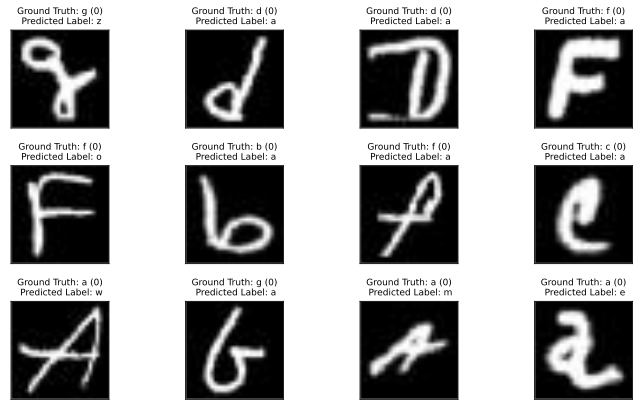

In [183]:
fig = plt.figure(figsize=(10, 6))

for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.tight_layout()
    np.transpose(pic, axes=(1, 0, 2))
    n = np.random.randint(len(mistakes[0]))
    letter = df['Letter'][df.Index == test_data.targets[n]].to_list()[0]
    n = n % 500
    onlyfiles = [f for f in listdir('images/test/' + letter) if isfile(join('images/test/' + letter, f))][n]
    pic = plt.imread('images/test/' + letter +'/' + onlyfiles)
    plt.imshow(np.transpose(pic, axes=(1, 0, 2)), cmap='gray', interpolation='none')
#     print(predicted_values[3].argmax(dim=1)[n].tolist())
    plt.title("Ground Truth: {} ({})\n Predicted Label: {}".format(
        letter,
        test_data.targets[n],
        df['Letter'][df.Index == predicted_values[3].argmax(dim=1)[n].tolist()].to_list()[0]),
                     fontsize=9)
    plt.xticks([])
    plt.yticks([])
    
plt.show()

**Comment:** *У некоторых букв (таких, как `f` (predicted `a`), `g` (predicted `a`) и другие, действительно можно спутать настоящее и распознанное значение, однако у других распознавание прошло крайне странно: ярко выраженные отличительные черты букв были не распознаны.*

**Comment:** *Первая буква моей фамилии (как в английском, так и в русскому варианте) - `K`. Точность детекции этой буквы - 407/500 или 81,4%. Чаще всего `k` путалась с `r` (41 раз)(скорее всего, связано с написанием заглавной R, которая может быть проидентифицирована как строчная k), `l` (25 раз)(возможно, это следствие особенностей почерка каждого человека, в том числе тех, чьи начертания были использованы в наборе данных) и `n` (14 раз)(опять же, думаю, что ошибки возникали из-за различного написания заглавной или строчной буквы).*

In [53]:
from plotly.subplots import make_subplots

In [54]:
def draw_loss_acc_plot(title, loss_list, acc_list):
    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    # Add traces
    fig.add_trace(
        go.Scatter(x=np.arange(len(loss_list)), y=loss_list, name="Loss", line={'width': 0.5, 'color': '#0F9F8A'}),
        secondary_y=False
    )

    fig.add_trace(
        go.Scatter(x=np.arange(len(loss_list)), y=np.array(acc_list) * 100, name="Accuracy", line={'width': 0.5, 'color': '#F51653'}),
        secondary_y=True
    )

    # Add figure title
    fig.update_layout(
        title_text=title, showlegend=False, width=990, height=600
    )

    # Set x-axis title
    fig.update_xaxes(mirror=False, 
                     ticks='outside', 
                     tickwidth=1.5,
                     showline=True,
                     linewidth=1.5,
                     linecolor='#48566A')

    # Set y-axes titles
    fig.update_yaxes(title_text="<i>Loss</i>",
                     range=(0, 5),
                     secondary_y=False,
                     ticks='outside', 
                     tickwidth=1.5)

    fig.update_yaxes(title_text="<i>Accuracy (%)</i>",
                     range=(0, 100),
                     secondary_y=True, 
                     mirror=True, 
                     ticks='outside', 
                     tickwidth=1.5,
                     showline=True,
                     linewidth=1.5,
                     linecolor='#48566A')

    fig.show()

**Comment:** *Построим Loss - Accuracy график. Видно, что по мере обучения модели точность растет (достаточно быстро сначала, затем медленнее), а потери снижаются.*

In [55]:
draw_loss_acc_plot("<b>PyTorch SimpleNN best results</b>", all_loss_lists[3], all_acc_lists[3])

### Модель с  тремя полносвязными слоями.

In [69]:
class SimpleNN3(nn.Module):
    def __init__(self, l1, l2):
        super(SimpleNN3, self).__init__() 
        self.flatten = Flatten()
        self.fc1 = nn.Linear(28*28*3, l1)
        self.fc2 = nn.Linear(l1, l2)
        self.fc3 = nn.Linear(l2, 26)
    
    def forward(self, x):
        # forward pass сети

        # переводим входной объект из картинки в вектор
        x = self.flatten(x)
        # умножение на матрицу весов 1 слоя и применение функции активации
        x = F.relu(self.fc1(x))
        # умножение на матрицу весов 2 слоя и применение функции активации
        x = F.relu(self.fc2(x))
        # умножение на матрицу весов 3 слоя и применение функции активации
        x = F.softmax(self.fc3(x))
        return x

In [153]:
params={'l1': [1970, 2580, 3000],
        'l2': [900, 1200, 2000],
        'batch_size': [250, 300, 500],
        'learning_rate': [0.001, 0.0025, 0.005, 0.01, 0.025]}

In [154]:
def main(params, num_epochs=5):
    
    all_loss_lists = []
    all_acc_lists = []
    test_results = []
    predicted_values = []
    
    for k in range(5):
        rand_params = []
        for key in list(params.keys()):
            rand_params.append([key, params[key][np.random.randint(len(params[key]))]])
#                         print(activation1, activation2, l1, learning_rate, batch_size)

        train_loader, test_loader = get_data(int(rand_params[2][1]))
        model, loss_list, acc_list = train(model=SimpleNN3(l1 = rand_params[0][1],
                                                           l2 = rand_params[1][1]),
                                           train_loader=train_loader,
                                           num_epochs=num_epochs,
                                           learning_rate=rand_params[3][1])
        all_loss_lists.append(loss_list)
        all_acc_lists.append(acc_list)
        accuracy, predicted = test(model=model, test_loader=test_loader)
        test_results.append([rand_params[i][1] for i in range(len(rand_params))] + [accuracy])
        predicted_values.append(predicted)
        print('Cycles: [{}/3] \tTest accuracy: {:.4f}%.'.format(k + 1, accuracy * 100))
        
    return all_loss_lists, all_acc_lists, test_results, predicted_values
    
if __name__ == "__main__":
    all_loss_lists_1, all_acc_lists_1, test_results_1, predicted_values_1 = main(params=params, num_epochs=5)

Cycles: [1/3] 	Test accuracy: 3.8462%.
Cycles: [2/3] 	Test accuracy: 3.8462%.
Cycles: [3/3] 	Test accuracy: 3.8462%.
Cycles: [4/3] 	Test accuracy: 3.8462%.
Cycles: [5/3] 	Test accuracy: 59.7769%.


In [155]:
for i in range(len(test_results_1)):
    test_results_1[i][-1] = round(test_results_1[i][-1] * 100, 4)

In [159]:
df_results = pd.DataFrame(test_results_1, columns=list(params.keys()) + ['accuracy, %'])
df_results

,l1,l2,batch_size,learning_rate,"accuracy, %"
0,1970,900,250,0.0050,3.8462
1,1970,1200,500,0.0010,3.8462
2,3000,2000,500,0.0010,3.8462
3,1970,900,300,0.0025,3.8462
4,1970,900,500,0.0010,59.7769


In [160]:
draw_confmatrix(test_data.targets, predicted_values_1[4].argmax(dim=1))

C:\Users\paxom\Anaconda\lib\site-packages\plotly\graph_objs\_deprecations.py:544: DeprecationWarning:

plotly.graph_objs.XAxis is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.XAxis
  - plotly.graph_objs.layout.scene.XAxis




**Comment:** *Модель, использующая функции активации Relu и Softmax, имеющая три полносвязных слоя, несмотря на вариации параметров, показала крайне низкие результаты.*

### Задание 2  
  
*Вес в общей оценке - 0.35*  
  
1. Постройте и обучите модели нейронной сети с 1-м, 2-мя и 3-мя сверточными слоями.  
Попробуйте различные значения параметров сверток и числа фильтров на каждом слое. Оцените качество моделей с различными параметрами, проведите сравнительный анализ.  
2. Для наилучшей конфигурации из предыдущего пункта, сравните, как меняется качество модели при увеличении размера батча при использовании BatchNorm и GroupNorm.    

### Модель с одним сверточным слоем.

In [99]:
params = [[5, 7, 11],
          [1, 1, 1],
          [2, 3, 5]]
params = np.array(params).T

In [100]:
class ConvNet1L(nn.Module): 
    def __init__(self, ks, s, p): 
        super(ConvNet1L, self).__init__() 
        self.layer1 = nn.Sequential(nn.Conv2d(3, 32, kernel_size=ks, stride=s, padding=p), 
                                    nn.ReLU(), nn.MaxPool2d(kernel_size=ks, stride=s, padding=p))
        self.drop_out = nn.Dropout() 
        self.fc1 = nn.Linear(25088, 26)
        
    def forward(self, x): 
        out = self.layer1(x)
        out = out.reshape(out.size(0), -1) 
        out = self.drop_out(out) 
        out = self.fc1(out)
        return out

**Comment:** *Построим модель с одним сверточным слоем, используя различное число фильтров, шагов и паддингов.*

In [102]:
def main(params, num_epochs=5):
    
    all_loss_lists = []
    all_acc_lists = []
    test_results = []
    predicted_values = []
    
    for i in range(len(params)):
        cnn_params = []
        train_loader, test_loader = get_data(512)
        model, loss_list, acc_list = train(model=ConvNet1L(ks=int(params[i][0]),
                                                           s=int(params[i][1]),
                                                           p=int(params[i][2])),
                                           train_loader=train_loader,
                                           num_epochs=num_epochs,
                                           learning_rate=0.001)
        all_loss_lists.append(loss_list)
        all_acc_lists.append(acc_list)
        accuracy, predicted = test(model=model, test_loader=test_loader)
        test_results.append([params[i]] + [accuracy])
        predicted_values.append(predicted)
        print('Cycles: [{}/3] \tTest accuracy: {:.4f}%.'.format(i + 1, accuracy * 100))
        
    return all_loss_lists, all_acc_lists, test_results, predicted_values
    
if __name__ == "__main__":
    all_loss_lists_2, all_acc_lists_2, test_results_2, predicted_values_2 = main(params=params, num_epochs=5)

Cycles: [1/3] 	Test accuracy: 89.9308%.
Cycles: [2/3] 	Test accuracy: 90.9462%.
Cycles: [3/3] 	Test accuracy: 91.2231%.


In [104]:
draw_loss_acc_plot("<b>PyTorch CNN best results</b>", all_loss_lists_2[2], all_acc_lists_2[2])

**Comment:** *Как видно, с увеличением числа фильтров, при неизменном размере шага, модели обучаются с каждым разом лучше. Однако разница в accuracy незначительная: около 1 %.*

### Модель с двумя сверточными слоями.

In [184]:
class ConvNet2L(nn.Module): 
    def __init__(self, ks, s, p): 
        super(ConvNet2L, self).__init__() 
        self.layer1 = nn.Sequential(nn.Conv2d(3, 32, kernel_size=ks, stride=s, padding=p), 
                                    nn.ReLU(), nn.MaxPool2d(kernel_size=ks, stride=s, padding=p)) 
        self.layer2 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=ks, stride=s, padding=p), 
                                    nn.ReLU(), nn.MaxPool2d(kernel_size=ks, stride=s, padding=p)) 
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(50176, 26)
        
    def forward(self, x): 
        out = self.layer1(x)
        out = self.layer2(out) 
        out = out.reshape(out.size(0), -1) 
        out = self.drop_out(out) 
        out = self.fc1(out)
        return out

**Comment:** *Попробуем обучить модель с двумя сверточными слоями с максимальным размером фильтров, который был в предыдущем пункте, - 11.*

In [185]:
train_loader, test_loader = get_data(512)
model, loss_list, acc_list = train(model=ConvNet2L(ks=11,
                                                   s=1,
                                                   p=5),
                                   train_loader=train_loader,
                                   num_epochs=5,
                                   learning_rate=0.001)

accuracy, predicted = test(model=model, test_loader=test_loader)
print('Test accuracy: {:.4f}%.'.format(accuracy * 100))

Test accuracy: 11.0000%.


**Comment:** *С учетом того, что данная часть кода работала часа три, а полученная точность составила 11.00%, можно сделать вывод о том, что большее количество фильтров в сочетании с большим количеством весов затрачивают лишние вычислительные мощности, время, а результат ухудшается.*

### Модель с тремя сверточными слоями.

**Comment:** *Попробуем уменьшить количество фильтров до минимального значения первого пункта и построим модель с двумя сверточными слоями.*

**Comment:** *Я не стала перезапускать данную часть кода из-за времени выполнения (как показал опыт - более 3-х часов, однако в предыдущие запуски модель демонстрировала точность около 92%.*

In [279]:
def train_1(model, train_loader, num_epochs, learning_rate):

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    total_step = len(train_loader)
    loss_list = []
    acc_list = []
    
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            
            # Прямой запуск
            outputs = model(images)
            loss = criterion(outputs, labels.type(torch.LongTensor))
            loss_list.append(loss.item())
            
            # Обратное распространение и оптимизатор
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Отслеживание точности
            total = labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()
            acc_list.append(correct / total)

            if (i + 1) % 100 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                      .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                              (correct / total) * 100))

    return model, loss_list, acc_list

In [ ]:
class ConvNet3L(nn.Module): 
    def __init__(self, ks, s, p): 
        super(ConvNet3L, self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(3, 32, kernel_size=ks, stride=s, padding=p), 
                                    nn.ReLU(), nn.MaxPool2d(kernel_size=ks, stride=s, padding=p)) 
        self.layer2 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=ks, stride=s, padding=p), 
                                    nn.ReLU(), nn.MaxPool2d(kernel_size=ks, stride=s, padding=p))
        self.layer3 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=ks, stride=s, padding=p), 
                                    nn.ReLU(), nn.MaxPool2d(kernel_size=ks, stride=s, padding=p)) 
        self.drop_out = nn.Dropout() 
        self.fc1 = nn.Linear(50176, 26)
        
    def forward(self, x): 
        out = self.layer1(x)
        out = self.layer2(out) 
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1) 
        out = self.drop_out(out) 
        out = self.fc1(out)
        return out

In [ ]:
train_loader, test_loader = get_data(512)
model, loss_list, acc_list = train(model=ConvNet2L(ks=5,
                                                   s=1,
                                                   p=1),
                                   train_loader=train_loader,
                                   num_epochs=5,
                                   learning_rate=0.001)
accuracy, predicted = test(model=model, test_loader=test_loader)
print('Test accuracy: {:.4f}%.'.format(accuracy * 100))

### Использование BatchNorm.

In [286]:
class ConvNet3LBN(nn.Module): 
    def __init__(self): 
        super(ConvNet3LBN, self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=1),
                                    nn.ReLU(), 
                                    nn.MaxPool2d(kernel_size=5, stride=1, padding=1,
                                                 dilation=1, ceil_mode=False),
                                    nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)) 
        self.layer2 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=1),
                                    nn.ReLU(), 
                                    nn.MaxPool2d(kernel_size=5, stride=1, padding=1, 
                                                 dilation=1, ceil_mode=False),
                                    nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
        self.layer3 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=1),
                                    nn.ReLU(), 
                                    nn.MaxPool2d(kernel_size=5, stride=1, padding=1,
                                                 dilation=1, ceil_mode=False),
                                    nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
        self.flatten = nn.Flatten() 
        self.fc1 = nn.Linear(32768, 26, bias=True)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out) 
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1) 
        out = self.flatten(out) 
        out = self.fc1(out)
        return out

**Comment:** *Построим модель с BatchNorm. Число фильтров возьмем: 5, stride = 1. Для MaxPool2d возьмем параметры kernel_size=5, stride=1, padding=1.*

In [287]:
train_loader, test_loader = get_data(batch_size=512)
model, loss_list, acc_list = train_1(model=ConvNet3LBN(), 
                                     train_loader=train_loader, 
                                     num_epochs=5,
                                     learning_rate=0.001)

Epoch [1/5], Step [100/127], Loss: 0.7632, Accuracy: 86.91%
Epoch [2/5], Step [100/127], Loss: 0.4294, Accuracy: 90.82%
Epoch [3/5], Step [100/127], Loss: 0.4082, Accuracy: 91.80%
Epoch [4/5], Step [100/127], Loss: 0.3369, Accuracy: 91.41%
Epoch [5/5], Step [100/127], Loss: 0.2876, Accuracy: 93.16%


In [288]:
accuracy, predicted = test(model=model, test_loader=test_loader)

In [290]:
print('Test accuracy: {:.4f}%.'.format(accuracy * 100))

Test accuracy: 90.6846%.


**Comment:** *Результаты трехслойной модели с BatchNorm впечатляют. Попробуем обучить на большем кол-ве эпох.*

In [291]:
train_loader, test_loader = get_data(batch_size=512)
model, loss_list, acc_list = train_1(model=ConvNet3LBN(), 
                                     train_loader=train_loader, 
                                     num_epochs=25,
                                     learning_rate=0.001)

Epoch [1/25], Step [100/127], Loss: 0.4342, Accuracy: 88.28%
Epoch [2/25], Step [100/127], Loss: 0.7525, Accuracy: 89.06%
Epoch [3/25], Step [100/127], Loss: 0.2961, Accuracy: 93.36%
Epoch [4/25], Step [100/127], Loss: 0.4084, Accuracy: 91.02%
Epoch [5/25], Step [100/127], Loss: 0.5215, Accuracy: 92.58%
Epoch [6/25], Step [100/127], Loss: 0.2903, Accuracy: 92.38%
Epoch [7/25], Step [100/127], Loss: 0.3656, Accuracy: 93.36%
Epoch [8/25], Step [100/127], Loss: 0.2484, Accuracy: 95.12%
Epoch [9/25], Step [100/127], Loss: 0.1435, Accuracy: 94.73%
Epoch [10/25], Step [100/127], Loss: 0.1958, Accuracy: 93.75%
Epoch [11/25], Step [100/127], Loss: 0.2232, Accuracy: 93.16%
Epoch [12/25], Step [100/127], Loss: 0.1802, Accuracy: 94.73%
Epoch [13/25], Step [100/127], Loss: 0.2080, Accuracy: 93.95%
Epoch [14/25], Step [100/127], Loss: 0.1328, Accuracy: 94.53%
Epoch [15/25], Step [100/127], Loss: 0.0779, Accuracy: 97.27%
Epoch [16/25], Step [100/127], Loss: 0.0644, Accuracy: 97.46%
Epoch [17/25], St

In [292]:
accuracy, predicted = test(model=model, test_loader=test_loader)

In [293]:
print('Test accuracy: {:.4f}%.'.format(accuracy * 100))

Test accuracy: 93.6000%.


**Comment:** *Наилучшие результаты показала модель с тремя сверточными слоями с фильтром 5х5, размером шага - 1, паддингом - 1 - 93,6 %. Если бы была возможность (вычислительные мощности ноута и время), то можно было увеличить количество эпох до 35, и натренировать модель на точность > 95 %.*

### Задание 3    
  
Обучите модель с точностью (accuracy) на тестовых данных:  
- `>= 0.85`    +1 балл
- `>= 0.95`    +2 балла
- `>= 0.99`    +3 балла  

## Бонусные задания

**Задание 1 (1 балл).**  

Напишите на листке белой бумаги (маркером или ручкой) от 5 разных букв (можно больше 5 букв в целом с повторениями, но должно быть минимум 5 разных) английского алфавита (в датасете есть как прописные, так и строчные буквы). Сфотографируйте букву и приведите её картинку к размеру $28\times28$ и, желательно, к чёрно-белой палитре цветов. Передайте получившиеся изображения вашей модели и выполните предсказание, оцените результат.  
  
**Tips:**  
- В датасете все буквы занимают практически всё пространство картинки по высоте или ширине (или вместе). Если ваша буква будет слишком маленькой или большой, это может повлиять на результат детекции.
- Помните, что буква должна быть белого цвета, а фон - чёрного.
- Описание ваших действий при выполнении этого задания (что вы использовали, чтобы привести картинку к нужному виду) категорически приветствуется :)

In [294]:
import os
import cv2
import torch
from string import ascii_letters

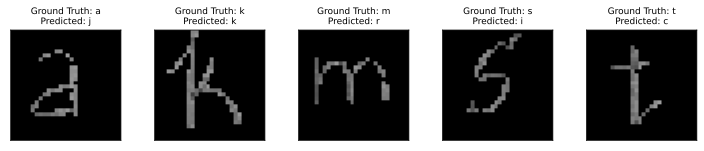

In [302]:
folder = 'images/samples/'
letters = {index: ascii_letters[index] for index in range(26)}

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

with torch.no_grad():
    fig = plt.figure(figsize=(10, 3))
    for i, n in enumerate([f for f in os.listdir(folder) if f.endswith('.jpg')]):
        real = cv2.imread(os.path.join(folder, n), cv2.IMREAD_COLOR)
        image = cv2.imread(os.path.join(folder, n), cv2.IMREAD_GRAYSCALE) # перевод в оттенки серого
        image = cv2.flip(image, 0) # вертикальное отражение
        img = cv2.resize(image[200:4000, 450:2400], (28, 28)) # изменение размера под входное значение
        img[img > 157] = 0 # варьируем threshhold
        img = np.stack([img, img, img]) # монохром -> RGB
        img = np.moveaxis(img, 0, -1)
        input_img = transform(img) # трансформация во входной формат
        out = model(input_img.unsqueeze(0))
        plt.subplot(1, 5, i + 1)
        plt.tight_layout()
        plt.imshow(np.transpose(img, axes=(1, 0, 2)))
        plt.title("Ground Truth: {}\nPredicted: {}".format(n.split('.')[0], letters[np.argmax(out).item()]), fontsize=9)
        plt.xticks([])
        plt.yticks([])
    plt.show()

**Comment:** *Верно распознана лишь буква `k`. Я думаю, что это из-за недостаточно качественного написания букв (в начальном тренировочном и тестовом наборе буквы написаны более "жирным" начертанием). Я писала эти буквы тонким маркером от руки, поэтому некоторые пиксели, образующие букву, потерялись, сами буквы получились очень тонкими, соответственно, меньше информации сохранилось для анализа, и модель могла спутать буквы с другими похожими.*

**Задание 2 (1 балл):**    
  
Используйте transfer learning подход для решения задачи - дообучите какую-либо модель, предобученную на ImageNet, для классификации рукописных букв. Оцените качество решения.  
В качестве предобученой модели можно взять одну из [torchvision models](https://pytorch.org/docs/stable/torchvision/models.html).

**Задание 3 (1 балл):**  
  
Добавьте вывод значений функции потерь и accuracy в tensorboard.  
Метрики нужно выводить и для обучающей, и для тестовой выборки.